In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib import patches
from matplotlib.pyplot import figure

import sys
sys.path.append('..')

# local library of functions to connect to image server
import calcimetry.use_server as server
from calcimetry.mongo_api import MongoInfo, MongoAPI


# Open Image and get calcimetry for image

In [3]:
img_path = server.init()  # initiate the global (privatevariables for the database

server : http://imgserver.10.68.0.250.nip.io/data/andra


In [4]:
mongo_info = MongoInfo()

In [5]:
drillname = 'OHZ5310'
with MongoAPI(mongo_info=mongo_info) as mongo_api:
    partialdrillname = f'.*{drillname}.*'
    doc = mongo_api.db['images'].find({'DrillName': {'$regex' : partialdrillname}})
    df = pd.DataFrame(list(doc))
df

,_id,ImageId,FileName,DrillName,Cote0,Cote1,PxSize,PySize,px0,px1,k_Up,k_Down,k_Arrow
0,632424f13f00570ad37de897,1437,GTR2020-02_0003-OHZ5310_0000_0108.JPG,OHZ5310,0,108,19113,4038,102,19073,"[[10578, 1263], [10624, 1256], [10860, 1269], ...","[[10542, 2458], [10823, 2360], [11250, 2495], ...","[[10719, 1731], [17861, 1619], [19092, 1667]]"
1,632424f13f00570ad37de898,1438,GTR2020-02_0003-OHZ5310_0078_0199.JPG,OHZ5310,78,199,5158,1019,5,5123,"[[4, 302], [601, 289], [1553, 300], [3524, 264...","[[8, 599], [378, 604], [974, 586], [1442, 586]...","[[6, 426], [3519, 413], [4531, 417], [5124, 386]]"
2,632424f13f00570ad37de899,1439,GTR2020-02_0003-OHZ5310_0170_0291.JPG,OHZ5310,170,291,5175,1005,18,5168,"[[11, 279], [653, 273], [1266, 268], [1680, 28...","[[18, 599], [616, 611], [1163, 609], [1256, 60...","[[15, 421], [1039, 417], [1108, 399], [1497, 4..."
3,632424f13f00570ad37de89a,1440,GTR2020-02_0003-OHZ5310_0261_0383.JPG,OHZ5310,261,383,5176,1009,31,5169,"[[2274, 388], [2387, 339], [2525, 351], [2721,...","[[2226, 615], [2320, 632], [2721, 634], [2989,...","[[2280, 481], [3015, 444], [3936, 429], [4472,..."
4,632424f13f00570ad37de89b,1441,GTR2020-02_0003-OHZ5310_0349_0431.JPG,OHZ5310,349,431,3638,1014,33,3540,"[[5, 284], [125, 281], [660, 290], [802, 331],...","[[2, 613], [82, 611], [441, 619], [856, 610], ...","[[26, 456], [1314, 470], [1386, 462], [1617, 4..."
5,632424f13f00570ad37de89c,1442,GTR2020-02_0003-OHZ5310_0431_0539.JPG,OHZ5310,431,539,4645,1016,72,4624,"[[69, 342], [157, 320], [1197, 319], [1689, 30...","[[64, 643], [176, 653], [881, 655], [1210, 657...","[[11, 512], [950, 502], [3418, 504], [3486, 48..."
6,632424f13f00570ad37de89d,1443,GTR2020-02_0003-OHZ5310_0508_0629.JPG,OHZ5310,508,629,5175,1040,26,5169,"[[4, 321], [240, 314], [362, 305], [457, 301],...","[[3, 652], [257, 650], [389, 636], [441, 632],...","[[2, 476], [155, 474], [829, 489], [2111, 465]..."
7,632424f13f00570ad37de89e,1444,GTR2020-02_0003-OHZ5310_0600_0720.JPG,OHZ5310,600,720,5175,1080,30,5141,"[[3, 333], [257, 331], [866, 314], [1572, 310]...","[[5, 668], [260, 668], [890, 653], [1585, 655]...","[[13, 522], [315, 521], [803, 494], [1958, 496..."
8,632424f13f00570ad37de89f,1445,GTR2020-02_0003-OHZ5310_0690_0811.JPG,OHZ5310,690,811,21568,4492,127,21459,"[[210, 1431], [1034, 1402], [1717, 1357], [296...","[[190, 2802], [1205, 2797], [1679, 2750], [566...","[[14, 2194], [141, 2190], [5334, 2044], [9332,..."
9,632424f13f00570ad37de8a0,1446,GTR2020-02_0003-OHZ5310_0776_0870.JPG,OHZ5310,776,870,4113,1020,1,3993,"[[24, 292], [387, 284], [927, 297], [1227, 285...","[[16, 618], [432, 616], [937, 625], [1266, 619...","[[14, 437], [894, 468], [1227, 460], [2601, 47..."


In [8]:
ImageID = 1437
with MongoAPI(mongo_info=mongo_info) as mongo_api:
    doc = mongo_api.db['measurements'].find({'ImageId': ImageID})
    df = pd.DataFrame(list(doc))
df

""


Status Code 200


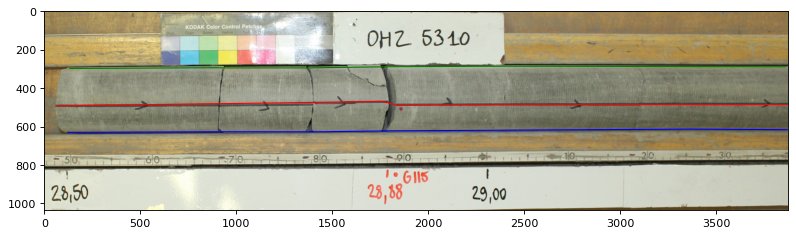

In [9]:
ImageId = 1437

def draw_line(polyline, color='red'):
    x = []
    y = []
    for t in polyline:
        x.append(t[0])
        y.append(t[1])
    apath = Path(list(zip(x, y)))
    apatch = patches.PathPatch(apath, linewidth=1, facecolor='none', edgecolor=color)
    return apatch

with MongoAPI(mongo_info=mongo_info) as mongo_api:
    doc = mongo_api.db['images'].find_one({'ImageId': ImageId})

    if len(doc['k_Up']) > 1:
        top_line = draw_line(doc['k_Up'], color='green')
    if doc['k_Arrow'] is not None:
        arrow_line = draw_line(doc['k_Arrow'], color='red')
    if len(doc['k_Down']) > 1:
        bottom_line = draw_line(doc['k_Down'], color='blue')

    filename = f"/data/andra/calci_photos/{drillname}/Photos/{doc['FileName']}"
    img = server.get_file(filename)

    figure(figsize=(12, 8), dpi=80)
    plt.imshow(img)
    if len(doc['k_Up']) > 1:
        plt.gca().add_patch(top_line)
    if doc['k_Arrow'] is not None:
        plt.gca().add_patch(arrow_line)
    if len(doc['k_Down']) > 1:
        plt.gca().add_patch(bottom_line)

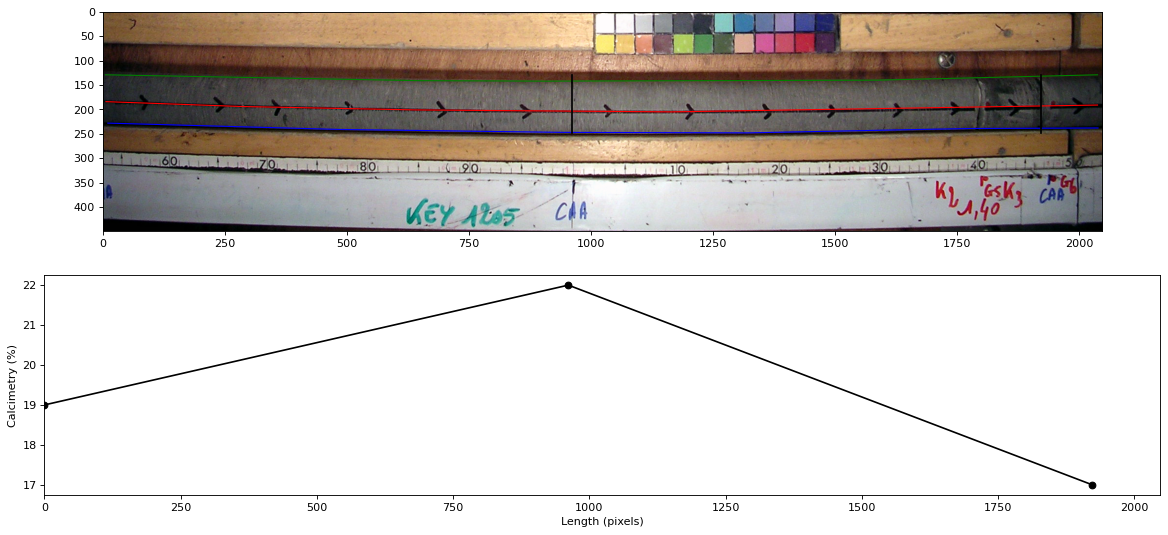

In [7]:
with MongoAPI(mongo_info=mongo_info) as mongo_api:
    doc = mongo_api.db['images'].find_one({'ImageId': ImageId})

    if len(doc['k_Up']) > 1:
        top_line = draw_line(doc['k_Up'], color='green')
    if doc['k_Arrow'] is not None:
        arrow_line = draw_line(doc['k_Arrow'], color='red')
    if len(doc['k_Down']) > 1:
        bottom_line = draw_line(doc['k_Down'], color='blue')

    filename = f"/data/andra/calci_photos/{drillname}/Photos/{doc['FileName']}"
    img = server.get_file(filename, quiet=True)

    figure(figsize=(18, 8), dpi=80)
    plt.subplot(211)
    plt.imshow(img)
    if len(doc['k_Up']) > 1:
        plt.gca().add_patch(top_line)
    if doc['k_Arrow'] is not None:
        plt.gca().add_patch(arrow_line)
    if len(doc['k_Down']) > 1:
        plt.gca().add_patch(bottom_line)
        
    dpxdx = (doc['px1'] - doc['px0']) / (doc['Cote1'] - doc['Cote0'])
        
    for indx, row in df.iterrows():
        if row['ImageId'] == ImageId:
            x = dpxdx * (row['CalciCote'] - doc['Cote0']) + doc['px0']
            y1 = np.array(doc['k_Down']).T[1].max()
            y2 = np.array(doc['k_Up']).T[1].min()
            plt.plot([x, x], [y1, y2], color='black')
    
    plt.subplot(212)
    
    x = []
    y = []
    for indx, row in df.iterrows():
        if row['ImageId'] == ImageId:
            x.append(dpxdx * (row['CalciCote'] - doc['Cote0']) + doc['px0'])
            y.append(row['CalciVals1m'])
    plt.plot(x, y, marker='o', color='black')
    plt.xlim(0, np.shape(img)[1])
    plt.ylabel('Calcimetry (%)')
    plt.xlabel('Length (pixels)')
            